In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Input pipeline

In [2]:
BUFFER_SIZE = 100
BATCH_SIZE = 60

seed = 0
f = np.load("data_gen/txt_data_nn.npz")

train_x = tf.data.Dataset.from_tensor_slices((f["imgs_0"][100:], f["labels_0"][100:])
                                            ).cache().shuffle(BUFFER_SIZE, seed, reshuffle_each_iteration=True).batch(BATCH_SIZE)
train_y = tf.data.Dataset.from_tensor_slices((f["imgs_1"][100:], f["labels_1"][100:])
                                            ).cache().shuffle(BUFFER_SIZE, seed, reshuffle_each_iteration=True).batch(BATCH_SIZE)
test_x = tf.data.Dataset.from_tensor_slices((f["imgs_0"][:100], f["labels_0"][:100])
                                            ).cache().shuffle(BUFFER_SIZE, seed, reshuffle_each_iteration=True).batch(BATCH_SIZE)
test_y = tf.data.Dataset.from_tensor_slices((f["imgs_1"][:100], f["labels_1"][:100])
                                            ).cache().shuffle(BUFFER_SIZE, seed, reshuffle_each_iteration=True).batch(BATCH_SIZE)

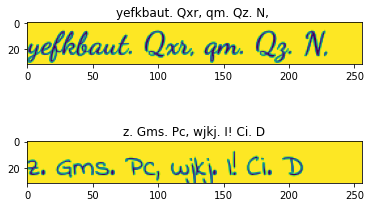

In [3]:
txt_map = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .,!"

def code_to_txt(code):
    return "".join([txt_map[i] for i in code])

def display_samples():
  sx = next(iter(test_x))
  imx = sx[0][0]
  lx = code_to_txt(sx[1][0])

  sy = next(iter(test_y))
  imy = sy[0][0]
  ly = code_to_txt(sy[1][0])

  plt.subplot(211)
  plt.title(lx)
  plt.imshow(imx)

  plt.subplot(212)
  plt.title(ly)
  plt.imshow(imy)

display_samples()

## Modified Pix2Pix models

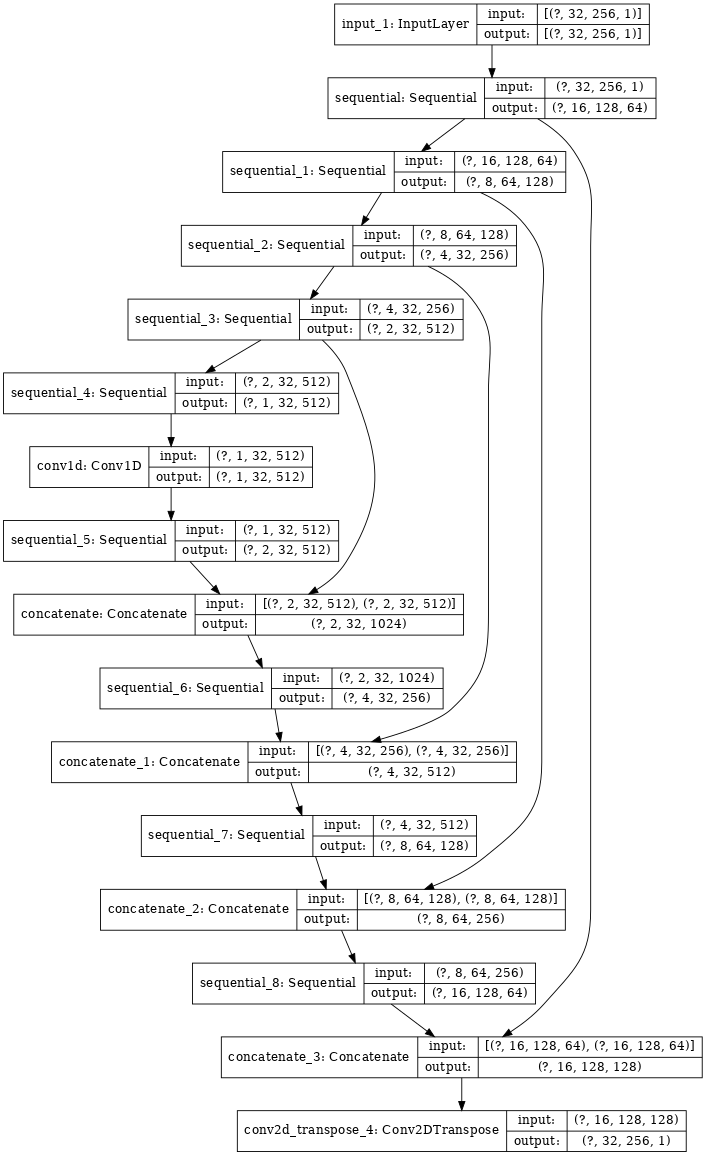

In [4]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tfa.layers.InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tfa.layers.InstanceNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def downsample_2(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=(2, 1), padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tfa.layers.InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample_2(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=(2, 1),
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tfa.layers.InstanceNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[32,256,1])

  nf = 64
  down_stack = [
    downsample(nf, 4, apply_batchnorm=False), # (bs, 16, 128, 64)
    downsample(nf*2, 4), # (bs, 8, 64, 128)
    downsample(nf*4, 4), # (bs, 4, 32, 256)
    downsample_2(nf*8, 4), # (bs, 2, 32, 512)
    downsample_2(nf*8, 4), # (bs, 1, 32, 512)
  ]

  up_stack = [
    upsample_2(nf*8, 4, apply_dropout=True), # (bs, 2, 32, 1024)
    upsample_2(nf*4, 4), # (bs, 4, 32, 512)
    upsample(nf*2, 4), # (bs, 8, 64, 256)
    upsample(nf, 4), # (bs, 16, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 32, 256, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  x = tf.keras.layers.Conv1D(512, 3, padding='same')(x)

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[32, 256, 1], name='input_image')

  nf = 64
  down1 = downsample(nf, 4, False)(inp) # (bs, 16, 128, 64)
  down2 = downsample(nf*2, 4)(down1) # (bs, 8, 64, 128)
  down3 = downsample(nf*4, 4)(down2) # (bs, 4, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(nf*8, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tfa.layers.InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
  conv2 = tf.keras.layers.Conv2D(nf*8, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad2)

  batchnorm2 = tfa.layers.InstanceNormalization()(conv2)

  leaky_relu2 = tf.keras.layers.LeakyReLU()(batchnorm2)
    
  zero_pad3 = tf.keras.layers.ZeroPadding2D()(leaky_relu2)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad3)

  return tf.keras.Model(inputs=inp, outputs=last)

generator_g = Generator()
generator_f = Generator()
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

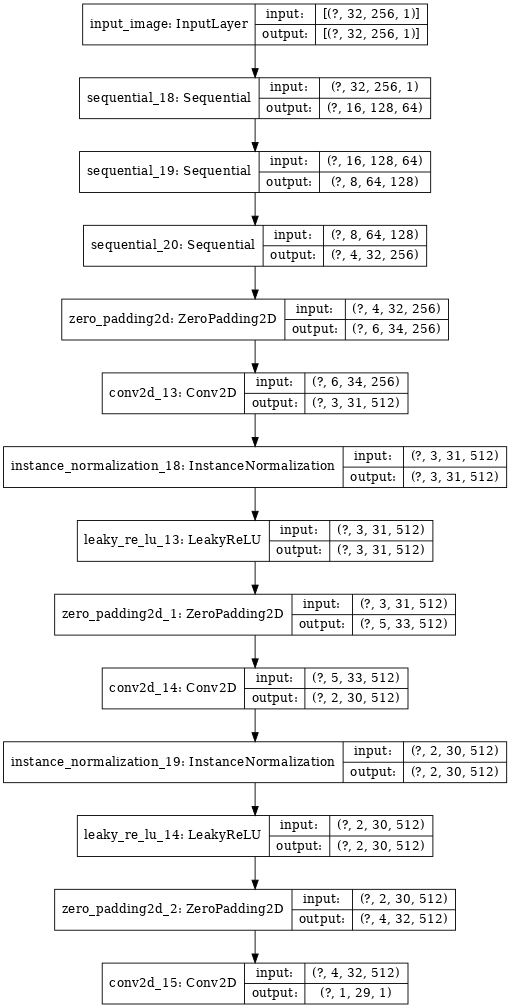

In [5]:
discriminator_x = Discriminator()
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

## Loss functions

In [6]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

def total_loss(batch_x, batch_y):
    real_x = batch_x[0]
    real_y = batch_y[0]
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    identity_loss_y = identity_loss(real_y, same_y)
    identity_loss_x = identity_loss(real_x, same_x)
    
    total_gen_g_loss = gen_g_loss + total_cycle_loss# + identity_loss_y
    total_gen_f_loss = gen_f_loss + total_cycle_loss# + identity_loss_x

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    loss_vec = tf.stack([total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss,
                         gen_g_loss, gen_f_loss, identity_loss_y, identity_loss_x, total_cycle_loss])
    return loss_vec

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [7]:
checkpoint_path = "./checkpoints/cyclegan-seq"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored.')

## Training

In [8]:
@tf.function
def train_step(batch_x, batch_y):
  with tf.GradientTape(persistent=True) as tape:
    loss_vec = total_loss(batch_x, batch_y)
    gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = loss_vec[0], loss_vec[1], loss_vec[2], loss_vec[3]
  gen_g_grad = tape.gradient(gen_g_loss, generator_g.trainable_variables)
  gen_f_grad = tape.gradient(gen_f_loss, generator_f.trainable_variables)
  disc_x_grad = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  disc_y_grad = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(gen_g_grad, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(gen_f_grad, generator_f.trainable_variables))
  discriminator_x_optimizer.apply_gradients(zip(disc_x_grad, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(disc_y_grad, discriminator_y.trainable_variables))

  return loss_vec

In [18]:
def generate_images(gen_f, gen_g, test_input):
  pred = gen_f(test_input)
  cycled = gen_g(pred)

  plt.figure(figsize=(12, 6))
  for j in range(len(pred)):

      display_list = [test_input[j], pred[j], cycled[j]]
      title = ['Input Image', 'Predicted Image', 'Cycled Image']

      for i in range(3):
        plt.subplot(len(pred), 3, j*3+i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
  plt.show()

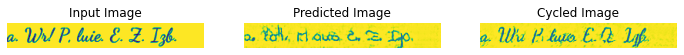

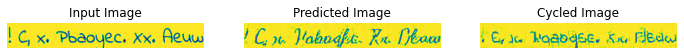

Saving checkpoint for epoch 20 at ./checkpoints/cyclegan-seq/ckpt-4
Time taken for epoch 20 is 107.0055763721466 sec



In [10]:
def train_cycle_gan(tsp = train_step, EPOCHS = 20):
  loss_log = []

  for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for batch_x, batch_y in tf.data.Dataset.zip((train_x, train_y)):
      loss = tsp(batch_x, batch_y)
      loss_log.append(loss)
      if n % 10 == 0:
        print ('.', end='')
      n+=1

    clear_output(wait=True)
    generate_images(generator_g, generator_f, batch_x[0][0:1])
    generate_images(generator_f, generator_g, batch_y[0][0:1])

    if (epoch + 1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
  return loss_log
loss_log = train_cycle_gan()

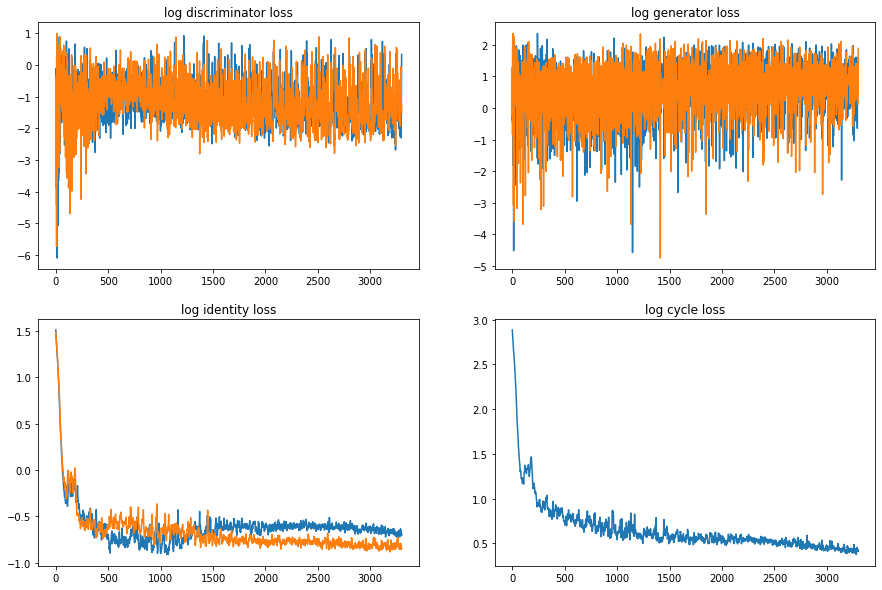

In [11]:
loss_log_np = np.log(np.array(loss_log))
t = np.arange(len(loss_log_np))
fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(15, 10)
for i in range(2, 4):
  axs[0,0].set_title("log discriminator loss")
  axs[0,0].plot(t, loss_log_np[:, i])
for i in range(4, 6):
  axs[0,1].set_title("log generator loss")
  axs[0,1].plot(t, loss_log_np[:, i])
for i in range(6, 8):
  axs[1,0].set_title("log identity loss")
  axs[1,0].plot(t, loss_log_np[:, i])
axs[1,1].set_title("log cycle loss")
axs[1,1].plot(t, loss_log_np[:, 8])

## Generate using test dataset

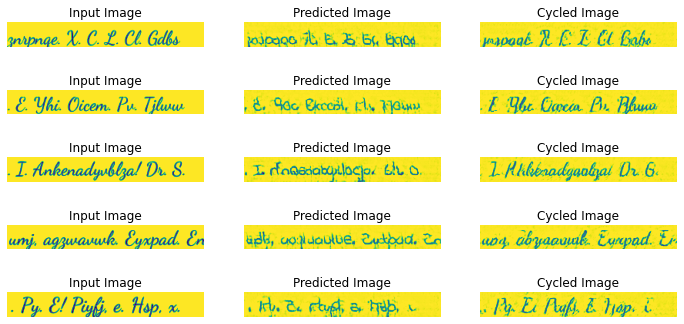

In [19]:
generate_images(generator_g, generator_f, next(iter(test_x))[0][:5])

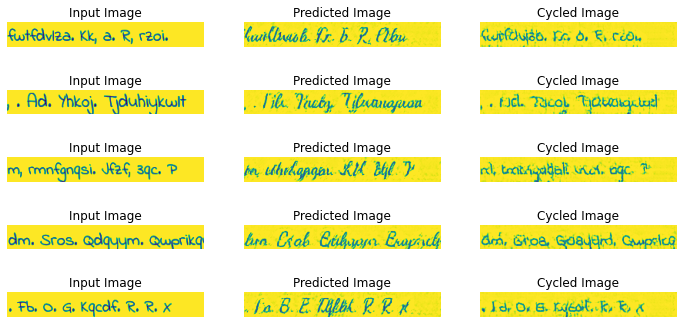

In [20]:
generate_images(generator_f, generator_g, next(iter(test_y))[0][:5])

## Classifier

In [14]:
def Classifier():
  inputs = tf.keras.layers.Input(shape=[32,256,1])

  x = inputs
  x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.transpose(x, [0, 2, 1, 3])
  x = tf.reshape(x, [-1, 32, 512])
  x = tf.transpose(x, [0, 2, 1])
  x = tf.keras.layers.Dense(26)(x)
  x = tf.transpose(x, [0, 2, 1])
  x = tf.keras.layers.GRU(512, return_sequences=True, go_backwards=True)(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.GRU(256, return_sequences=True, go_backwards=True)(x)
  x = tf.keras.layers.GRU(66, return_sequences=True, go_backwards=True)(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

class_x = Classifier()
class_y = Classifier()

In [15]:
class_x.compile(optimizer='adam', 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
class_x.fit(train_x, epochs=70)

Epoch 1/70
165/165 [==============================] - 5s 29ms/step - loss: 3.6886 - accuracy: 0.1677
Epoch 2/70
165/165 [==============================] - 5s 30ms/step - loss: 3.6738 - accuracy: 0.1709
Epoch 3/70
165/165 [==============================] - 5s 29ms/step - loss: 3.6732 - accuracy: 0.1709
Epoch 4/70
165/165 [==============================] - 4s 27ms/step - loss: 3.6708 - accuracy: 0.1723
Epoch 5/70
165/165 [==============================] - 5s 29ms/step - loss: 3.6687 - accuracy: 0.1723
Epoch 6/70
165/165 [==============================] - 5s 27ms/step - loss: 3.6557 - accuracy: 0.1605
Epoch 7/70
165/165 [==============================] - 5s 30ms/step - loss: 3.5329 - accuracy: 0.1660
Epoch 8/70
165/165 [==============================] - 4s 25ms/step - loss: 3.2527 - accuracy: 0.2489
Epoch 9/70
165/165 [==============================] - 5s 27ms/step - loss: 2.9760 - accuracy: 0.3558
Epoch 10/70
165/165 [==============================] - 5s 29ms/step - loss: 2.7524 - accura

In [16]:
class_y.compile(optimizer='adam', 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
class_y.fit(train_y, epochs=70)

Epoch 1/70
165/165 [==============================] - 5s 30ms/step - loss: 3.6964 - accuracy: 0.1657
Epoch 2/70
165/165 [==============================] - 5s 30ms/step - loss: 3.6731 - accuracy: 0.1669
Epoch 3/70
165/165 [==============================] - 4s 26ms/step - loss: 3.6581 - accuracy: 0.1487
Epoch 4/70
165/165 [==============================] - 5s 30ms/step - loss: 3.5711 - accuracy: 0.1472
Epoch 5/70
165/165 [==============================] - 5s 30ms/step - loss: 3.3321 - accuracy: 0.1585
Epoch 6/70
165/165 [==============================] - 5s 28ms/step - loss: 3.0971 - accuracy: 0.1581
Epoch 7/70
165/165 [==============================] - 4s 27ms/step - loss: 2.9413 - accuracy: 0.1927
Epoch 8/70
165/165 [==============================] - 5s 30ms/step - loss: 2.8125 - accuracy: 0.2508
Epoch 9/70
165/165 [==============================] - 5s 30ms/step - loss: 2.7233 - accuracy: 0.2730
Epoch 10/70
165/165 [==============================] - 5s 29ms/step - loss: 2.6645 - accura

In [17]:
print("test_x accuracy")
class_x.evaluate(test_x)

print("test_y accuracy")
class_y.evaluate(test_y)

@tf.function
def gen_g_map(img, label):
  return (generator_g(img), label)

@tf.function
def gen_f_map(img, label):
  return (generator_f(img), label)

print("fake x accuracy")
class_x.evaluate(test_y.map(gen_f_map))

print("fake y accuracy")
class_y.evaluate(test_x.map(gen_g_map))

test_x accuracy
2/2 [==============================] - 0s 37ms/step - loss: 2.4009 - accuracy: 0.8512
test_y accuracy
2/2 [==============================] - 0s 4ms/step - loss: 2.4734 - accuracy: 0.7919
fake x accuracy
2/2 [==============================] - 0s 133ms/step - loss: 3.8030 - accuracy: 0.2096
fake y accuracy
2/2 [==============================] - 0s 133ms/step - loss: 3.7847 - accuracy: 0.1946


[3.7847442626953125, 0.19461537897586823]